In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Une bibliothèque de visualisation de données basée sur matplotlib. Elle permet de créer des graphiques plus attrayants et informatifs.
from ucimlrepo import fetch_ucirepo # permet d'importer facilement des datasets du UCI Machine Learning Repository en Python.
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,StackingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score,auc,roc_curve
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import random
import joblib
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures

In [2]:
# ====================================================================
# ÉTAPE 1: CHARGEMENT DES DONNÉES
# ====================================================================

# Chargement du dataset Cleveland depuis UCI Repository (ID 45)
heart_disease = fetch_ucirepo(id=45)

# Extraction des features et target (en DataFrames pandas)
X_cleveland = heart_disease.data.features  # Features
y_cleveland = heart_disease.data.targets   # Target (variable 'num')

# Liste des noms de colonnes pour uniformiser les datasets
feature_columns = X_cleveland.columns.tolist()  # Colonnes des features
target_column = 'num'                          # Nom de la target
all_columns = feature_columns + [target_column]  # Toutes colonnes

def load_dataset(filename):
    """
    Charge un dataset à partir d'un fichier CSV et le formate correctement.
    
    Args:
        filename (str): Chemin vers le fichier CSV
        
    Returns:
        tuple: (Features, Target) sous forme de DataFrames pandas
    """
    # Lecture du CSV avec:
    # - Pas d'en-tête (header=None)
    # - Noms de colonnes standardisés
    # - Valeurs manquantes marquées par '?'
    df = pd.read_csv(filename, sep=",", header=None, 
                    names=all_columns, na_values='?')
    
    return df[feature_columns], df[target_column]

# Chargement des 3 autres datasets
X_hungarian, y_hungarian = load_dataset("Data-set\processed.hungarian.data")
X_switzerland, y_switzerland = load_dataset("Data-set\processed.switzerland.data")
X_va, y_va = load_dataset("Data-set\processed.va.data")

# Concaténation de tous les datasets en un seul
X = pd.concat([X_cleveland, X_hungarian, X_switzerland, X_va], 
              axis=0, ignore_index=True)
y = pd.concat([y_cleveland['num'], y_hungarian, y_switzerland, y_va], 
              axis=0, ignore_index=True)

# ====================================================================
# ÉTAPE 2: NETTOYAGE DES DONNÉES
# ====================================================================

# Suppression des doublons dans les features
X.drop_duplicates(inplace=True)

# Synchronisation de la target avec les features après suppression des doublons
y = y.loc[X.index]

# Conversion de la target en binaire (0 = pas de maladie, 1 = maladie)
# Original: 0 = pas de maladie, 1-4 = différents niveaux de maladie
y_binary = np.where(y > 0, 1, 0)

# Affichage des valeurs manquantes avant traitement
print("Valeurs manquantes dans X avant imputation:")
print(X.isnull().sum())

print("\nValeurs manquantes dans y avant traitement:")
print(y.isnull().sum())

# ====================================================================
# ÉTAPE 3: IMPUTATION DES VALEURS MANQUANTES
# ====================================================================

# Création d'un imputeur qui remplace les NaN par la médiane de chaque colonne
imputer = SimpleImputer(strategy='median')

# Application de l'imputation (convertit en numpy array puis retour en DataFrame)
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Vérification après imputation
print("\nValeurs manquantes dans X après imputation:")
print(X.isnull().sum())

# ====================================================================
# ÉTAPE 4: FEATURE ENGINEERING (CRÉATION DE NOUVELLES VARIABLES)
# ====================================================================

def create_features(df):
    """
    Crée de nouvelles variables à partir des données existantes.
    
    Args:
        df (DataFrame): DataFrame contenant les features
        
    Returns:
        DataFrame: DataFrame avec les nouvelles variables ajoutées
    """
    # Pression pulsée: différence entre pression artérielle au repos et fréquence cardiaque max
    if 'trestbps' in df.columns and 'thalach' in df.columns:
        df['pulse_pressure'] = df['trestbps'] - df['thalach']
    
    # Création de groupes d'âge (catégorisation)
    if 'age' in df.columns:
        df['age_group'] = pd.cut(df['age'], 
                                bins=[0, 40, 50, 60, 70, 100],
                                labels=['<40', '40-50', '50-60', '60-70', '70+'])
    
    return df

# Application de la fonction de feature engineering
X = create_features(X)

# Suppression de la variable 'age' originale car nous avons créé des catégories
X = X.drop(columns=['age'])

# ====================================================================
# ÉTAPE 5: ENCODAGE DES VARIABLES CATÉGORIELLES
# ====================================================================

# One-Hot Encoding pour 'age_group' (supprime la première catégorie pour éviter la colinéarité)
X = pd.get_dummies(X, columns=['age_group'], drop_first=True)

# Conversion des colonnes booléennes (issues du One-Hot Encoding) en entiers (0/1)
bool_columns = X.select_dtypes(include='bool').columns
X[bool_columns] = X[bool_columns].astype(int)

# One-Hot Encoding pour les autres variables catégorielles médicales
X_encoded = pd.get_dummies(X, columns=['cp', 'restecg', 'slope', 'thal'], drop_first=True)

# Conversion des nouvelles colonnes booléennes en entiers
bool_columns = X_encoded.select_dtypes(include='bool').columns
X_encoded[bool_columns] = X_encoded[bool_columns].astype(int)

# ====================================================================
# ÉTAPE 6: NORMALISATION DES DONNÉES
# ====================================================================

# Création d'un scaler standard (moyenne=0, écart-type=1)
scaler = StandardScaler()

# Application de la normalisation (convertit en numpy array puis retour en DataFrame)
X_encoded = pd.DataFrame(scaler.fit_transform(X_encoded), columns=X_encoded.columns)

# ====================================================================
# ÉTAPE 7: SÉPARATION TRAIN/TEST
# ====================================================================

# Séparation avec:
# - 20% de test
# - random_state pour la reproductibilité
# - stratification pour conserver la proportion de classes
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_binary, test_size=0.2, random_state=42, stratify=y_binary)


# ====================================================================
# MODÉLISATION 
# ====================================================================

def plot_roc_curve(y_test, y_pred_proba, label):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Ligne en pointillés pour un modèle aléatoire
    plt.xlabel('Taux de faux positifs (FPR)')
    plt.ylabel('Taux de vrais positifs (TPR)')
    plt.title('Courbe ROC')
    plt.legend(loc='lower right')

knn_model = KNeighborsClassifier()

# Define the parameter grid
param_grid = {
    'n_neighbors': [ 3,5,10],  # Nombre de voisins
    'weights': ['uniform'],  # Pondération des voisins uniform : Tous les voisins ont le même poids(vote majoritaire). distance : Les voisins plus proches ont un poids plus important( Le poids d'un voisin est calculé comme 1/distance).                        # Paramètre de distance
    'metric': ['manhattan']  # Métrique de distance
}

# Configurer GridSearchCV
grid_search = GridSearchCV(
    estimator=knn_model,
    param_grid=param_grid,
    scoring='accuracy',  # Métrique d'évaluation
    cv=5,               # Nombre de folds pour la validation croisée
    verbose=1,          # Afficher les détails de l'exécution
    n_jobs=-1           # Utiliser tous les cœurs du CPU
)

# Fit the model
grid_search.fit(X_train, y_train)
best_model3 = grid_search.best_estimator_
y_pred_knn = best_model3.predict(X_test)
y_pred_proba_knn = best_model3.predict_proba(X_test)[:, 1]  # Probabilités pour la classe positives

# Sauvegarder le modèle KNN optimisé
joblib.dump(best_model3, 'models/knn_heart_disease_model.pkl')

# Sauvegarder le StandardScaler
joblib.dump(scaler, 'models/heart_disease_scaler.pkl')

# Sauvegarder la liste des colonnes attendues
import json
with open('feature_columns.json', 'w') as f:
    json.dump(X_encoded.columns.tolist(), f)


Valeurs manquantes dans X avant imputation:
age           0
sex           0
cp            0
trestbps     59
chol         29
fbs          90
restecg       2
thalach      55
exang        55
oldpeak      62
slope       307
ca          609
thal        484
dtype: int64

Valeurs manquantes dans y avant traitement:
0

Valeurs manquantes dans X après imputation:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
dtype: int64
Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [3]:
train_accuracy = accuracy_score(y_train, best_model3.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred_knn)

train_auc = roc_auc_score(y_train, best_model3.predict_proba(X_train)[:, 1])
test_auc = roc_auc_score(y_test, y_pred_proba_knn)

print(f"Train Accuracy: {train_accuracy:.2f} | Test Accuracy: {test_accuracy:.2f}")
print(f"Train ROC AUC: {train_auc:.2f} | Test ROC AUC: {test_auc:.2f}")

Train Accuracy: 0.82 | Test Accuracy: 0.88
Train ROC AUC: 0.91 | Test ROC AUC: 0.92


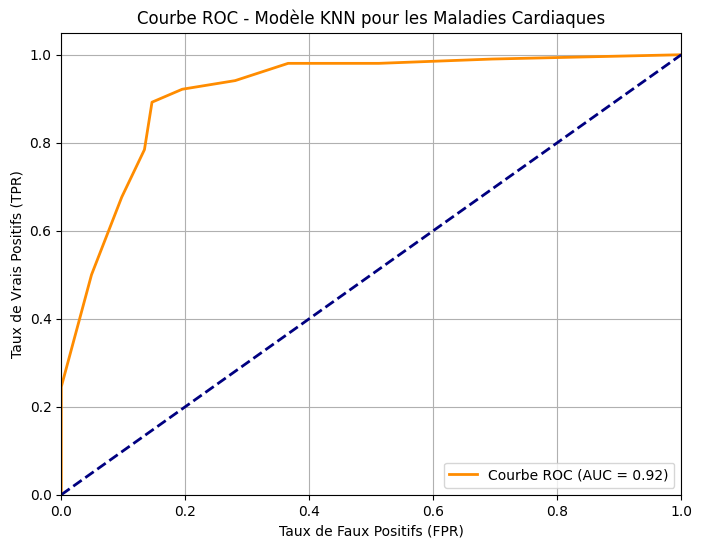

In [4]:
y_pred_proba_knn = best_model3.predict_proba(X_test)[:, 1]

# Calcul des points pour la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_knn)
roc_auc = auc(fpr, tpr)

# Création du plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Ligne aléatoire
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC - Modèle KNN pour les Maladies Cardiaques')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [5]:
# 1. Définir le modèle et la grille d'hyperparamètres
rf_model = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100,200],       # Nombre d'arbres
    'max_depth': [10,20],       # Profondeur max (None = illimitée)
    'min_samples_split': [10,20],      # Nombre min d'échantillons pour diviser un nœud
    'min_samples_leaf': [5,10],        # Nombre min d'échantillons dans une feuille
    'bootstrap': [True]                # Bootstrap pour réduire l'overfitting
}

# 2. GridSearchCV pour optimiser les paramètres
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,                              # Validation croisée stratifiée
    n_jobs=-1,
    verbose=1
)

# 3. Entraînement sur les données (X_train, y_train)
grid_search_rf.fit(X_train, y_train)

# 4. Meilleur modèle
best_rf = grid_search_rf.best_estimator_

# Sauvegarder le modèle KNN optimisé
#joblib.dump(best_rf, 'models/rf_heart_disease_model.pkl')

# 5. Évaluation
print("=== Random Forest ===")
print("Meilleurs paramètres:", grid_search_rf.best_params_)
print("Train Accuracy:", accuracy_score(y_train, best_rf.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, best_rf.predict(X_test)))
print("Test ROC AUC:", roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1]))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
=== Random Forest ===
Meilleurs paramètres: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
Train Accuracy: 0.8828337874659401
Test Accuracy: 0.8532608695652174
Test ROC AUC: 0.9243185078909613


In [6]:
from sklearn.linear_model import LogisticRegression # type: ignore

lr_model = LogisticRegression(max_iter=1000, random_state=42)
param_grid = {
    'C': [0.1, 1],  # Régularisation (plus petit = plus de régularisation)
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

grid_search_lr = GridSearchCV(lr_model, param_grid, cv=10, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_lr.fit(X_train, y_train)
best_lr = grid_search_lr.best_estimator_

Fitting 10 folds for each of 2 candidates, totalling 20 fits


In [7]:
from sklearn.svm import SVC # type: ignore

svm_model = SVC(probability=True, random_state=42)
param_grid = {
    'C': [0.1, 1],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale']
}

grid_search_svm = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_svm.fit(X_train, y_train)
best_svm = grid_search_svm.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [8]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    max_depth=3,           # Réduire la profondeur (typiquement 3-6)
    learning_rate=0.1,     # Valeur classique
    n_estimators=100,      # Nombre d'arbres modéré
    subsample=0.8,         # Stochastic Gradient Boosting
    colsample_bytree=0.8,  # Sélection aléatoire des features
    reg_alpha=1,           # L1 regularization
    reg_lambda=1,          # L2 regularization
    min_child_weight=3,    # Contrôle la division des nœuds
    random_state=42
)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [9]:
from lightgbm import LGBMClassifier # type: ignore

lgbm_model = LGBMClassifier(random_state=42)
param_grid = {
    'n_estimators': [100],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [31, 63]
}

grid_search_lgbm = GridSearchCV(lgbm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_lgbm.fit(X_train, y_train)
best_lgbm = grid_search_lgbm.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Info] Number of positive: 406, number of negative: 328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 472
[LightGBM] [Info] Number of data points in the train set: 734, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553134 -> initscore=0.213340
[LightGBM] [Info] Start training from score 0.213340
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn


=== Régression Logistique ===
Train Accuracy: 0.8160762942779292
Test Accuracy: 0.8097826086956522
Test ROC AUC: 0.9177427068388331
              precision    recall  f1-score   support

           0       0.81      0.74      0.78        82
           1       0.81      0.86      0.83       102

    accuracy                           0.81       184
   macro avg       0.81      0.80      0.81       184
weighted avg       0.81      0.81      0.81       184



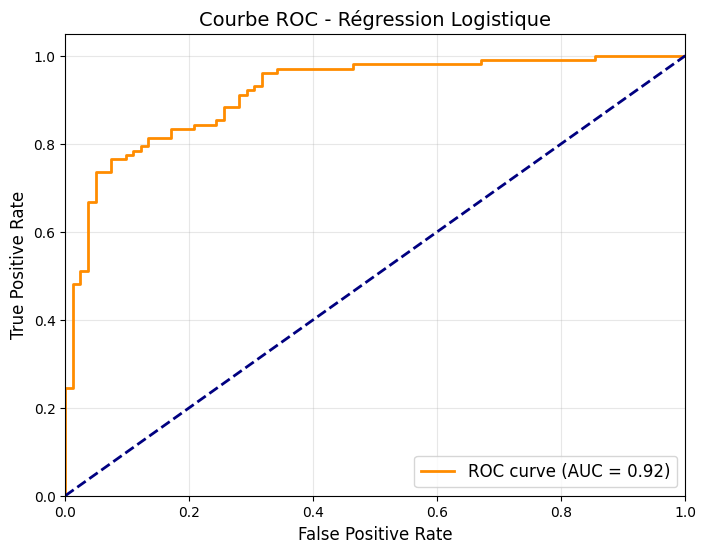


=== SVM ===
Train Accuracy: 0.8242506811989101
Test Accuracy: 0.8152173913043478
Test ROC AUC: 0.9225251076040172
              precision    recall  f1-score   support

           0       0.82      0.74      0.78        82
           1       0.81      0.87      0.84       102

    accuracy                           0.82       184
   macro avg       0.82      0.81      0.81       184
weighted avg       0.82      0.82      0.81       184



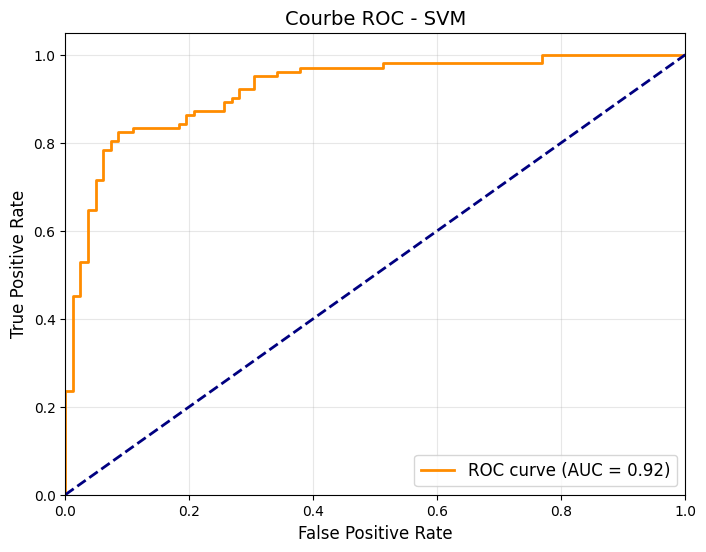


=== XGBoost ===
Train Accuracy: 0.8828337874659401
Test Accuracy: 0.875
Test ROC AUC: 0.932209469153515
              precision    recall  f1-score   support

           0       0.90      0.80      0.85        82
           1       0.86      0.93      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.87      0.87       184
weighted avg       0.88      0.88      0.87       184



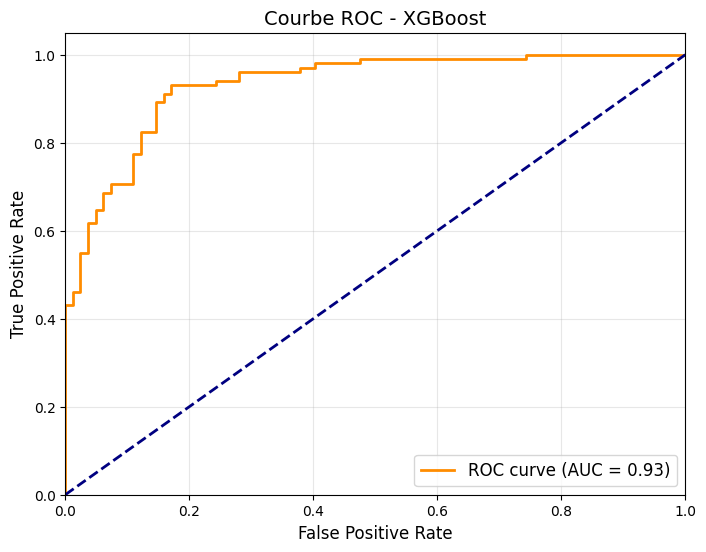


=== LightGBM ===
Train Accuracy: 0.8746594005449592
Test Accuracy: 0.8586956521739131
Test ROC AUC: 0.9369918699186992
              precision    recall  f1-score   support

           0       0.86      0.82      0.84        82
           1       0.86      0.89      0.88       102

    accuracy                           0.86       184
   macro avg       0.86      0.85      0.86       184
weighted avg       0.86      0.86      0.86       184



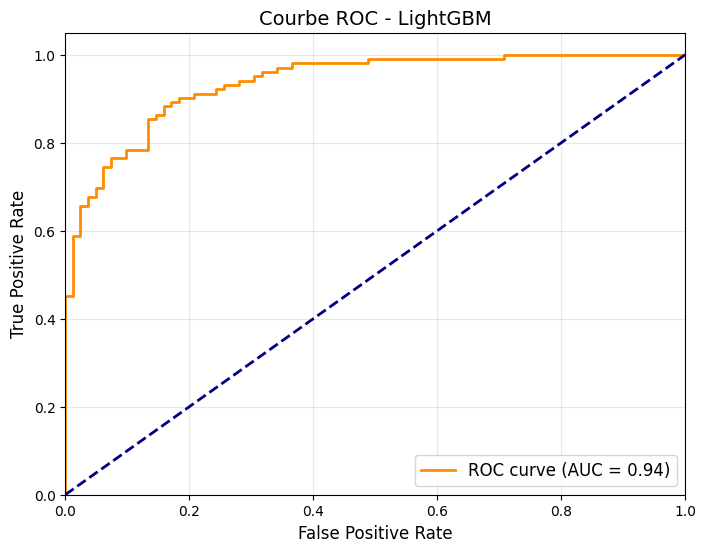


=== Forêt Aléatoire ===
Train Accuracy: 0.8828337874659401
Test Accuracy: 0.8532608695652174
Test ROC AUC: 0.9243185078909613
              precision    recall  f1-score   support

           0       0.87      0.79      0.83        82
           1       0.84      0.90      0.87       102

    accuracy                           0.85       184
   macro avg       0.86      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184



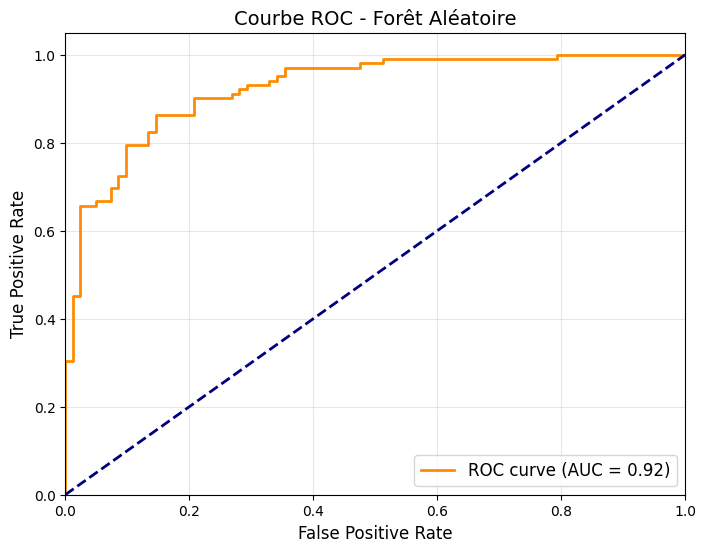

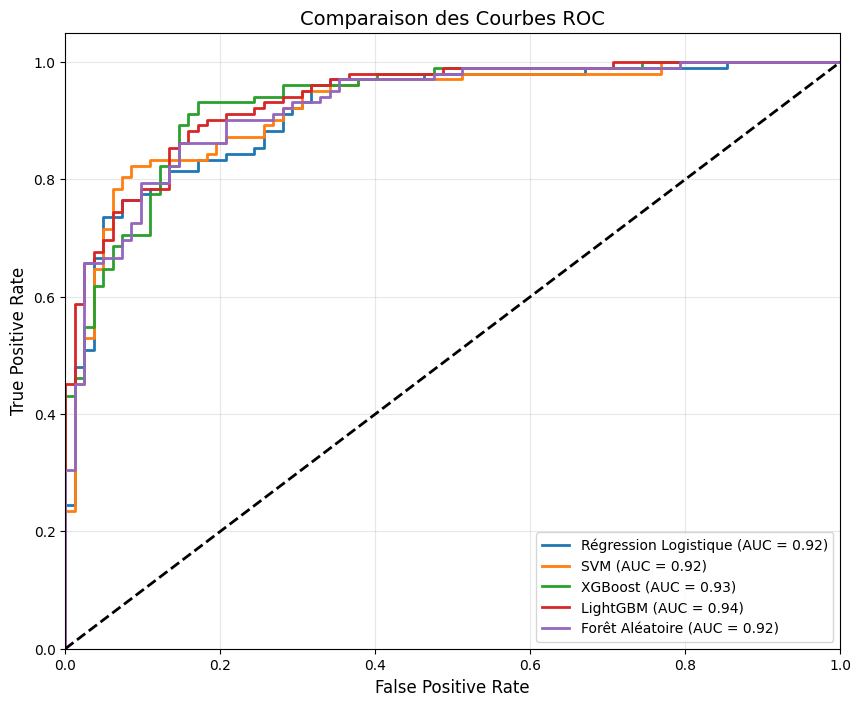

In [10]:
def evaluate_model(model, model_name):
    # Prédictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Métriques
    print(f"\n=== {model_name} ===")
    print("Train Accuracy:", accuracy_score(y_train, model.predict(X_train)))
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    
    if hasattr(model, "predict_proba"):
        print("Test ROC AUC:", roc_auc_score(y_test, y_proba))
    print(classification_report(y_test, y_pred))
    
    # Courbe ROC individuelle seulement si le modèle peut fournir des probabilités
    if hasattr(model, "predict_proba"):
        plt.figure(figsize=(8, 6))
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc_score = roc_auc_score(y_test, y_proba)
        
        # Personnalisation du graphique
        plt.plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'ROC curve (AUC = {auc_score:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title(f'Courbe ROC - {model_name}', fontsize=14)
        plt.legend(loc="lower right", fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.show()

# Dictionnaire des modèles
models = {
    "Régression Logistique": best_lr,
    "SVM": best_svm,
    "XGBoost": xgb_model,
    "LightGBM": best_lgbm,
    "Forêt Aléatoire": best_rf
}

# Évaluation de chaque modèle avec courbe ROC individuelle
for name, model in models.items():
    evaluate_model(model, name)

# (Optionnel) Courbe ROC comparative globale
plt.figure(figsize=(10, 8))
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc_score = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, lw=2, 
                label=f'{name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Comparaison des Courbes ROC', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

Visualisation et analyse complète des performances de chaque modèle sous différents angles (learning curve)

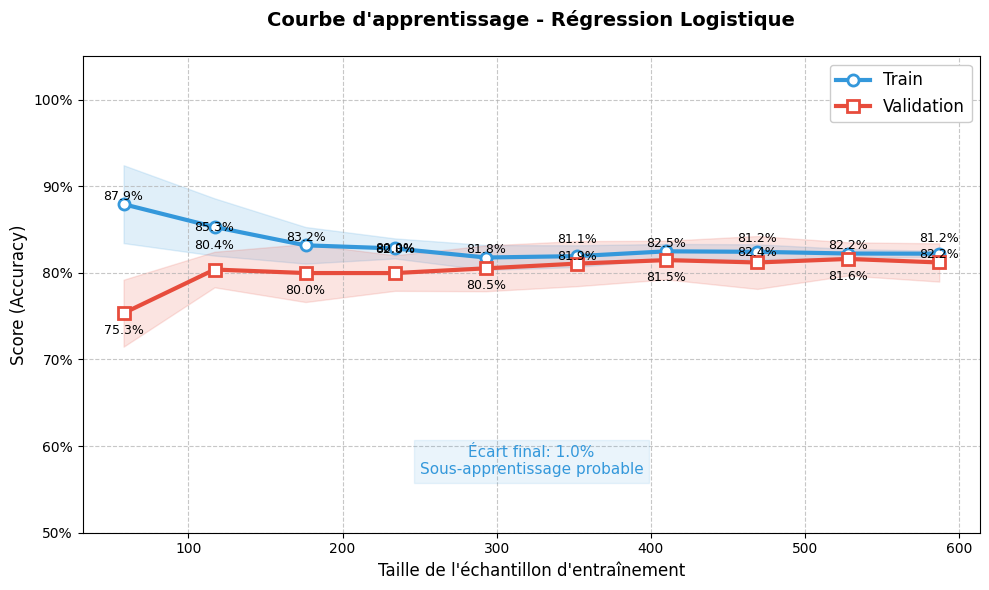

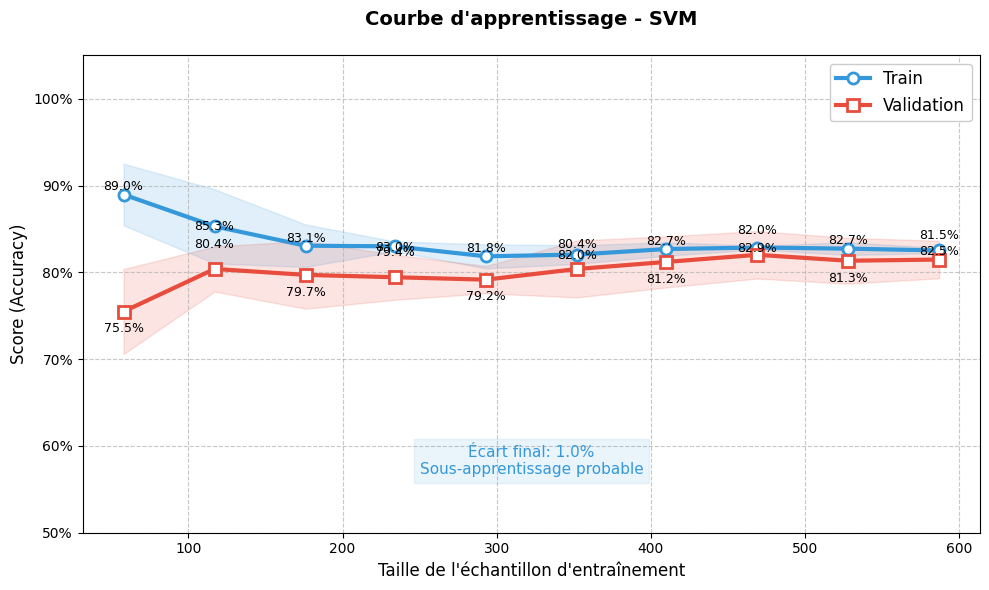

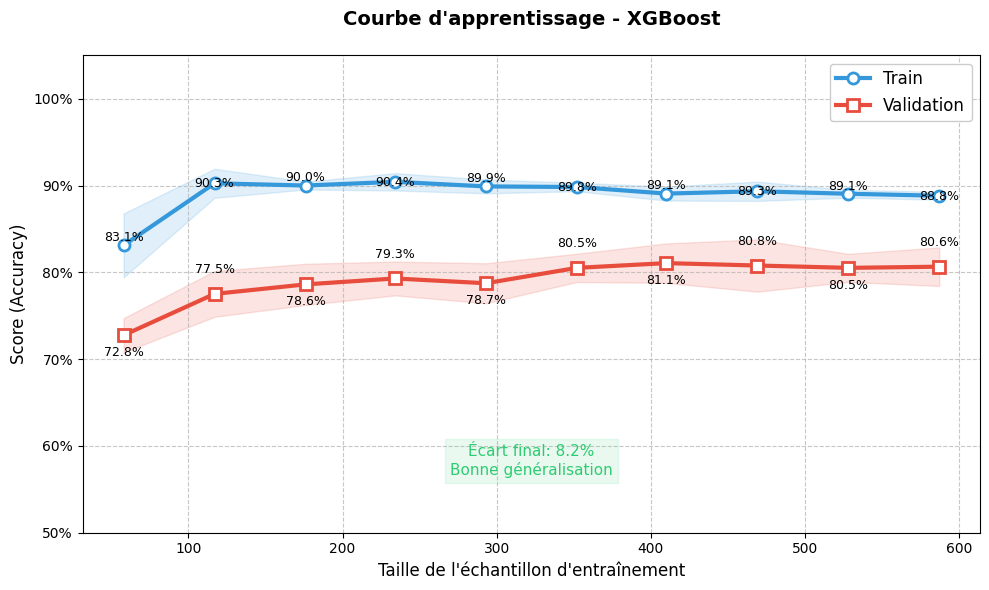

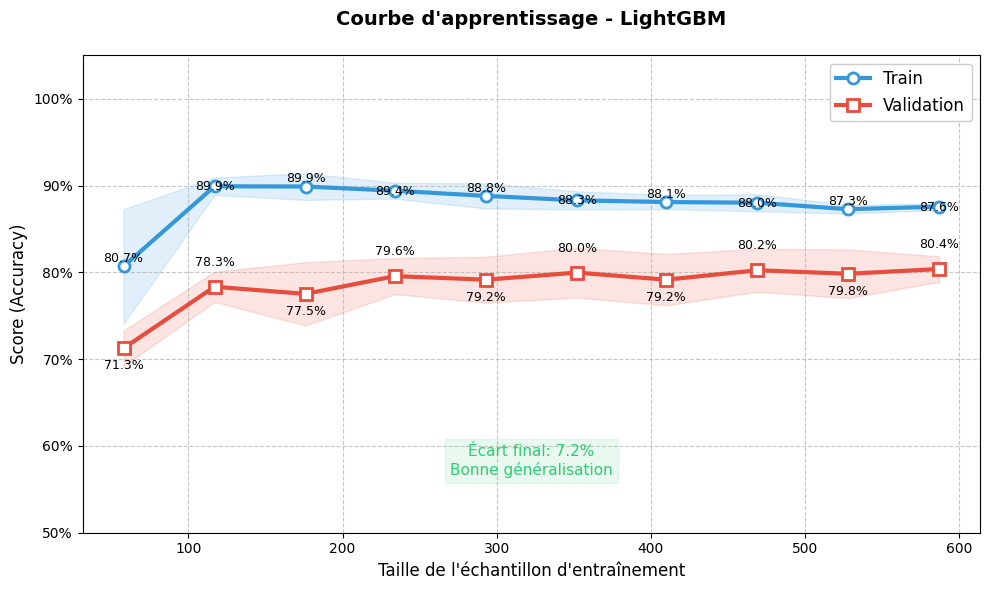

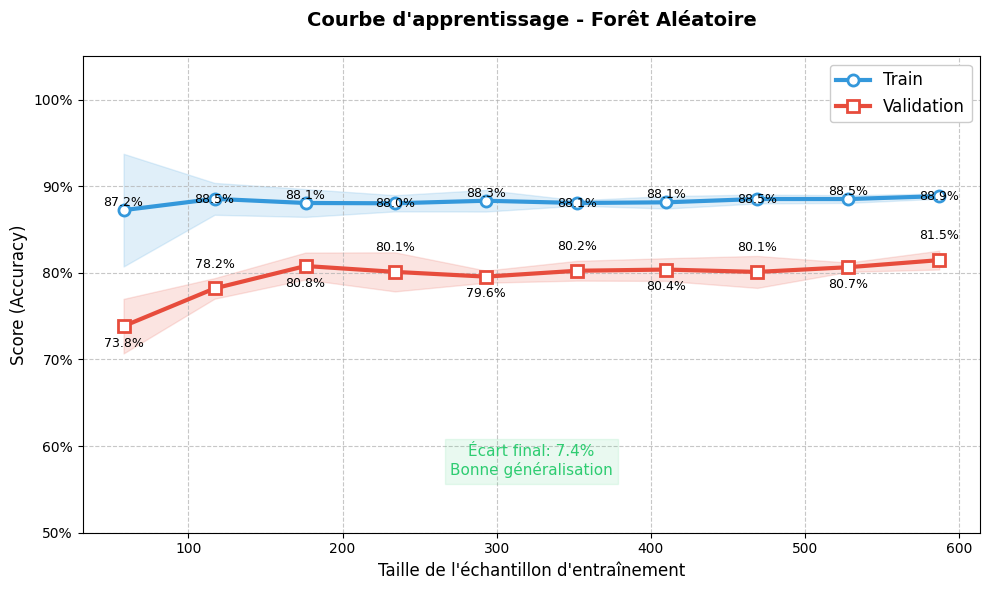

In [11]:
"""
Les scores de validation correspondent à une validation croisée (5 folds) sur le jeu d'entraînement seulement

Calculés sur des sous-ensembles partiels des données (de 10% à 100% de X_train)

But : Observer comment le modèle apprend avec moins de données

"""


from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

def plot_learning_curve(model, model_name, scoring='accuracy', figsize=(10, 6)):
    # Calcul des courbes
    train_sizes, train_scores, val_scores = learning_curve(
        estimator=model,
        X=X_train,
        y=y_train,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=5,
        scoring=scoring,
        n_jobs=-1,
        random_state=42,
        shuffle=True
    )

    # Calcul des statistiques
    train_mean = np.mean(train_scores, axis=1) * 100 if scoring == 'accuracy' else np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1) * 100 if scoring == 'accuracy' else np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1) * 100 if scoring == 'accuracy' else np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1) * 100 if scoring == 'accuracy' else np.std(val_scores, axis=1)

    # Création du graphique
    plt.figure(figsize=figsize)
    
    # Courbe d'entraînement
    plt.plot(train_sizes, train_mean, 'o-', color='#3498DB', linewidth=3, 
             markersize=8, markerfacecolor='white', markeredgewidth=2, 
             label='Train')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std,
                    color='#3498DB', alpha=0.15)
    
    # Courbe de validation
    plt.plot(train_sizes, val_mean, 's-', color='#E74C3C', linewidth=3, 
             markersize=8, markerfacecolor='white', markeredgewidth=2,
             label='Validation')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std,
                    color='#E74C3C', alpha=0.15)

    # Personnalisation avancée
    title_font = {'fontsize': 14, 'fontweight': 'bold'}
    axis_font = {'fontsize': 12}
    
    plt.title(f'Courbe d\'apprentissage - {model_name}\n', **title_font)
    plt.xlabel('Taille de l\'échantillon d\'entraînement', **axis_font)
    plt.ylabel('Score (%s)' % ('Accuracy' if scoring == 'accuracy' else 'AUC-ROC'), **axis_font)
    
    # Format des axes y en pourcentage si accuracy
    if scoring == 'accuracy':
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
        plt.ylim(50, 105)
    else:
        plt.ylim(0.5, 1.05)
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='best', fontsize=12, framealpha=1)
    
    # Ajout des valeurs annotées
    for i, (trn, val) in enumerate(zip(train_mean, val_mean)):
        offset = 3 if i % 2 == 0 else -3  # Alterne la position des annotations
        plt.annotate(f'{trn:.1f}{"%" if scoring == "accuracy" else ""}', 
                    (train_sizes[i], trn), 
                    textcoords="offset points", xytext=(0, offset), 
                    ha='center', fontsize=9)
        plt.annotate(f'{val:.1f}{"%" if scoring == "accuracy" else ""}', 
                    (train_sizes[i], val), 
                    textcoords="offset points", xytext=(0, -15 if offset > 0 else 15), 
                    ha='center', fontsize=9)

    # Diagnostic
    final_gap = train_mean[-1] - val_mean[-1]
    if final_gap > 10 if scoring == 'accuracy' else final_gap > 0.1:
        color = '#E74C3C'
        conclusion = 'Surapprentissage probable'
    elif final_gap < 2 if scoring == 'accuracy' else final_gap < 0.02:
        color = '#3498DB'
        conclusion = 'Sous-apprentissage probable'
    else:
        color = '#2ECC71'
        conclusion = 'Bonne généralisation'
    
    plt.text(0.5, 0.15 if scoring == 'accuracy' else 0.6, 
             f'Écart final: {final_gap:.1f}{"%" if scoring == "accuracy" else ""}\n{conclusion}',
             transform=plt.gca().transAxes, bbox=dict(facecolor=color, alpha=0.1, edgecolor=color),
             ha='center', va='center', fontsize=11, color=color)
    
    plt.tight_layout()
    plt.show()

# Utilisation :
for name, model in models.items():
    plot_learning_curve(model, name, scoring='accuracy')  # Changer en 'roc_auc' si besoin

approche pour créer des modèles ensemblistes cherchons d'améliorer la performance de notre système

Noms des estimateurs: ['lr', 'xgb', 'rf']

=== Optimized Voting Classifier ===
Train Accuracy: 0.8746594005449592
Test Accuracy: 0.8804347826086957
Test ROC AUC: 0.9319703491152559
              precision    recall  f1-score   support

           0       0.91      0.82      0.86        82
           1       0.86      0.93      0.90       102

    accuracy                           0.88       184
   macro avg       0.88      0.87      0.88       184
weighted avg       0.88      0.88      0.88       184



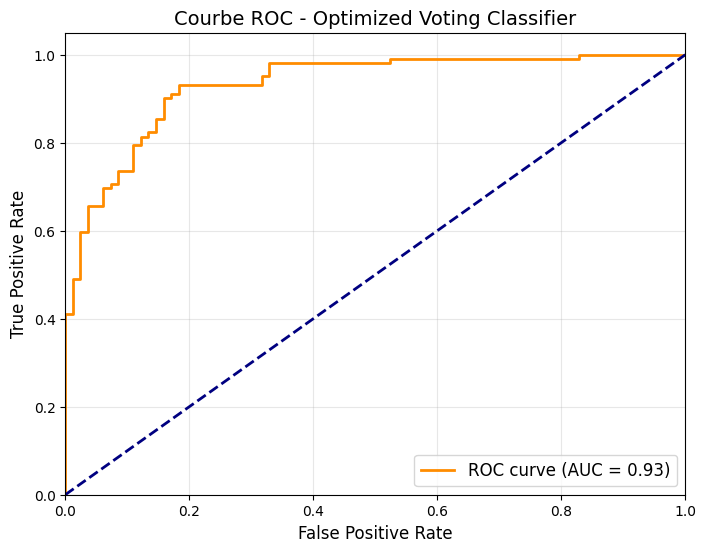

['models/heart_disease_mixmodels.pkl']

In [12]:
# L'Ensemble Learning  or Voting Classifier (Hard & Soft Voting)

#hard ->retourner la classe majoritaire
#soft ->Au lieu de voter pour une classe, on calcule la moyenne des probabilités données par chaque modèle, puis on choisit la classe avec la plus grande probabilité moyenne

from sklearn.ensemble import VotingClassifier

# Création du Voting Classifier (soft voting si les modèles ont predict_proba)
voting_clf = VotingClassifier(
    estimators=[
        ('lr', best_lr),
        ('xgb', xgb_model),
        ('rf', best_rf)
    ],
    voting='soft'  # 'hard' si certains modèles n'ont pas predict_proba
)

voting_clf.fit(X_train, y_train)

print("Noms des estimateurs:", [name for name, _ in voting_clf.estimators])

params = {
    'voting': ['soft', 'hard'],
    'weights': [
        (1,1,1),    # poids égaux
        (2,1,1),     # premier modèle 2x plus important
        (1,2,1),     # deuxième modèle 2x plus important
        (1,1,2)      # troisième modèle 2x plus important
    ]
}

# 4. Lancez la recherche de grille
grid_voting = GridSearchCV(
    voting_clf,
    param_grid=params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_voting.fit(X_train, y_train)
evaluate_model(grid_voting.best_estimator_, "Optimized Voting Classifier")
# Sauvegarder le StandardScaler
joblib.dump(grid_voting.best_estimator_, 'models/heart_disease_mixmodels.pkl')

In [ ]:
import sys

print("Version de Python :", sys.version)
print("Informations de version :", sys.version_info)